In [1]:
from io import open
import glob
import os

In [2]:
print(glob.glob('datasets/data/names/*.txt'))

['datasets/data/names\\Arabic.txt', 'datasets/data/names\\Chinese.txt', 'datasets/data/names\\Czech.txt', 'datasets/data/names\\Dutch.txt', 'datasets/data/names\\English.txt', 'datasets/data/names\\French.txt', 'datasets/data/names\\German.txt', 'datasets/data/names\\Greek.txt', 'datasets/data/names\\Irish.txt', 'datasets/data/names\\Italian.txt', 'datasets/data/names\\Japanese.txt', 'datasets/data/names\\Korean.txt', 'datasets/data/names\\Polish.txt', 'datasets/data/names\\Portuguese.txt', 'datasets/data/names\\Russian.txt', 'datasets/data/names\\Scottish.txt', 'datasets/data/names\\Spanish.txt', 'datasets/data/names\\Vietnamese.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [4]:
n_letters

57

In [5]:
language_names = {}

all_languages = []

In [6]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [7]:
print(unicode_to_ascii('Émile'))

Emile


In [8]:
def find_files(path):
    return glob.glob(path)

In [9]:
total_names = 0

for filename in find_files('datasets/data/names/*.txt'):
    
    language = os.path.splitext(os.path.basename(filename))[0]
    all_languages.append(language)
    
    read_names = open(filename, encoding='utf-8').read().strip().split('\n')
    names = [unicode_to_ascii(line) for line in read_names]
    
    language_names[language] = names
    
    total_names += len(names)

In [10]:
all_languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [11]:
total_names

20074

In [12]:
import torch

In [13]:
def letter_to_tensor(letter):
    
    tensor = torch.zeros(1, n_letters)
    tensor[0][all_letters.find(letter)] = 1
    
    return tensor

In [14]:
print(letter_to_tensor('B'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [15]:
def name_to_tensor(name):
    
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for li, letter in enumerate(name):
        tensor[li][0][all_letters.find(letter)] = 1
        
    return tensor

In [16]:
nt = name_to_tensor('Mary')
nt.shape

torch.Size([4, 1, 57])

In [17]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [18]:
n_hidden = 256
n_languages = len(all_languages)

rnn = RNN(n_letters, n_hidden, n_languages)

In [19]:
#Example of how it works during training
inp = letter_to_tensor('R')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(inp, hidden)

print('output size = ', output.size())
print('next_hidden size = ', next_hidden.size())

output size =  torch.Size([1, 18])
next_hidden size =  torch.Size([1, 256])


In [20]:
inp = name_to_tensor('Ron')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(inp[0], hidden)

print(output) #Log softmax probability scores

tensor([[-2.9151, -2.8910, -2.9541, -2.8831, -2.9012, -2.8269, -2.8733, -2.8877,
         -2.9804, -2.8843, -2.9052, -2.8848, -2.9482, -2.8789, -2.8214, -2.8899,
         -2.8984, -2.8183]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
print(next_hidden.shape)

torch.Size([1, 256])


In [22]:
# output from rnn needs to be converted to language name

def language_from_output(output):
    _, top_i = output.topk(1) #idx of highest probability
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [23]:
print(language_from_output(output))

('Vietnamese', 17)


In [44]:
import random

def random_training_example():
    random_language_idx = random.randint(0, n_languages - 1)
    language = all_languages[random_language_idx]
    
    random_language_names = language_names[language]
    name = random_language_names[random.randint(0, len(random_language_names) - 1)]
    
    language_tensor = torch.tensor([all_languages.index(language)], dtype=torch.long)
    name_tensor = name_to_tensor(name)
    
    return language, name, language_tensor, name_tensor

In [45]:
for i in range(5):
    language, name, language_tensor, name_tensor = random_training_example()
    print('name = ', name, ', language = ', language)

name =  Cowie , language =  English
name =  Lam , language =  Vietnamese
name =  Olivier , language =  French
name =  Marino , language =  Italian
name =  Victors , language =  French


In [46]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [50]:
def train(language_tensor, name_tensor):
    
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

        
    loss = criterion(output, language_tensor)
    loss.backward()
    
    #Can use optimiser
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

In [48]:
n_epochs = 200000

current_loss = 0.0
all_losses = []

In [51]:
for epoch in range(1, n_epochs + 1):
    
    language, name, language_tensor, name_tensor = random_training_example()
    
    output, loss = train(language_tensor, name_tensor)
    current_loss += loss
    
    if epoch % 5000 == 0:
        pred, pred_i = language_from_output(output)
        correct = '✔' if pred == language else '✘ (%s)' %language
        
        print('%d %d%% %.4f %s / %s %s' % (epoch,
                                          epoch / n_epochs * 100,
                                          loss,
                                          name,
                                          pred,
                                          correct))
        
    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

5000 2% 3.2093 Denis / Greek ✘ (French)
10000 5% 2.9562 Ochoa / Russian ✘ (Spanish)
15000 7% 2.3459 Glatter / French ✘ (Czech)
20000 10% 1.1650 Ho / Korean ✔
25000 12% 1.4083 Ha / Korean ✘ (Vietnamese)
30000 15% 0.9848 Oh  / Korean ✔
35000 17% 1.5624 Connolly / Scottish ✘ (Irish)
40000 20% 1.9498 Tipping / Scottish ✘ (English)
45000 22% 4.8469 Jelen / German ✘ (Polish)
50000 25% 0.4151 Romao / Portuguese ✔
55000 27% 2.8094 Esyp / Polish ✘ (Russian)
60000 30% 0.2347 Touma / Arabic ✔
65000 32% 0.0725 Khoury / Arabic ✔
70000 35% 0.0615 Shadid / Arabic ✔
75000 37% 0.6797 Banderas / Spanish ✔
80000 40% 0.9011 Langlais / French ✔
85000 42% 1.2807 Quaranta / Italian ✔
90000 45% 4.2312 Cernohous / Irish ✘ (Czech)
95000 47% 0.5434 Gabler / German ✔
100000 50% 2.0474 Korycansky / Russian ✘ (Czech)
105000 52% 1.0847 Hughes / Scottish ✔
110000 55% 1.8465 Krol / Scottish ✘ (Polish)
115000 57% 0.5525 Papageorge / Greek ✔
120000 60% 3.7785 Tremble / Scottish ✘ (French)
125000 62% 0.1257 Kowalczyk / P

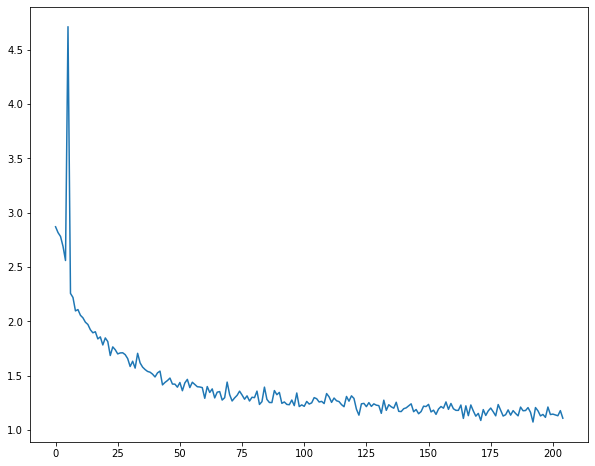

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(all_losses)
plt.show()

In [53]:
n_pred = 3

In [58]:
input_name = 'Bukoski'

In [59]:
with torch.no_grad():
    
    name_tensor = name_to_tensor(input_name)
    
    hidden = rnn.init_hidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    topv, topi = output.topk(n_pred, 1, True)
    
    for i in range(n_pred):
        value = topv[0][i].item()
        language_idx = topi[0][i].item()
        
        print('(%.2f) %s' % (value, all_languages[language_idx]))

(-0.05) Polish
(-4.05) Russian
(-4.45) Czech
